This notebook looks at the NOAA data off the west coast of BC and US.

In [25]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sets import Set
import calendar
import seaborn as sns

sns.set_style("darkgrid")

%matplotlib inline

In [2]:
def csvWOD_readcasts(fnm,MAX_CASTS = -1):
    '''
    csvWOD_readcasts
    inputs:
    fnm -- the filename of the CSV data from WOD13 database
    MAX_CASTS (optional) -- maximum number of casts to parse
    desc:
    Takes a filename and reads all casts from the CSV file. 
    Parses through each section of the CSV and creates a list of 
    dictionary objects. Each dictionary object contains information
    about the cast.
    
    Future versions:
    While reading, it would be useful to filter out useless data...
    - filter by certain parameters; lat, lon, year, etc.
    - filter by available variables (e.g. only want casts with Nitrate)
    '''
    
    # get the raw, unparsed CSV data
    csvdat =  csv.reader(open(fnm,'rb'))
    
    # all_casts is the list of dictionaries, containing cast info
    all_casts = []
    
    # num_casts keeps track of the number of casts parsed
    num_casts = 0

    # set the initial read state to Not Applicable
    READ_STATE = 'N/A'

    # read line by line -- this saves on memory
    for count,row in enumerate(csvdat):
        # empty rows begin with a '#'
        if row[0].startswith('#'):
            # set the read state to N/A 
            # this line shouldn't be reached
            READ_STATE = 'N/A'
        # if our read state is N/A, we're expecting a 'CAST' info line to come up
        elif READ_STATE == 'N/A':
            # only move from this state if we get a 'CAST' info line
            if row[0][0:4] == 'CAST':
                # we have one more cast found
                num_casts+=1
                # don't want to read too many casts -- break if we reached the limit
                if num_casts == MAX_CASTS:
                    break
                    
                # otherwise, we're in good shape, append the WOD identifier onto it
                all_casts.append({'WOD_UCN' : int(row[2]), 'Variables' : [], 'Units' : []})
                # and change the current parsing state to 'CAST'
                READ_STATE = 'CAST'
        # read state 'CAST' means that we're parsing through the CAST metadata
        elif READ_STATE == 'CAST':
            # lots of different meta data options here
            # NODC_CID is going to be unused; remove?
            if row[0].startswith('NODC Cruise ID'):
                # strip off excess whitespace on the right
                all_casts[-1]['NODC_CID'] = row[2].rstrip()
            # read in the latitude
            elif row[0].startswith('Latitude'):
                all_casts[-1]['Latitude'] = float(row[2])
            # read in the longitude
            elif row[0].startswith('Longitude'):
                all_casts[-1]['Longitude'] = float(row[2])
            # read in date information
            elif row[0].startswith('Year'):
                all_casts[-1]['Year'] = int(row[2])
            elif row[0].startswith('Month'):
                all_casts[-1]['Month'] = int(row[2])
            elif row[0].startswith('Day'):
                all_casts[-1]['Day'] = int(row[2])
            # read in time information; this is a decimal format for time
            elif row[0].startswith('Time'):
                all_casts[-1]['Time'] = float(row[2])
            # if we read a VARIABLES line, set the read state to VARIABLES metadata
            elif row[0].startswith('VARIABLES'):
                READ_STATE = 'VARIABLES_META'
                # loop through this row, append any variables to a list within the dictionary
                for ii in range(1,len(row),3):
                    if len(row[ii].rstrip()) > 0:
                        # set the specific variable data to an empty list
                        all_casts[-1][row[ii].rstrip()] = []
                        # append the variable name to a list
                        all_casts[-1]['Variables'].append(row[ii].rstrip())
        # read state 'VARIABLES_META' parses units, and skips over unused 'Prof-..' line
        elif READ_STATE == 'VARIABLES_META':
            # read in the units of each variable
            if row[0].startswith('UNITS'):
                # get the correct columns
                for ii in range(1,len(row),3):
                    if len(row[ii].rstrip()) > 0:
                        # append the units onto the Units list
                        all_casts[-1]['Units'].append(row[ii].rstrip())
            # skip over unused row
            elif row[0].startswith('Prof'):
                # set the read state to 'VARIABLES_READ'
                READ_STATE = 'VARIABLES_READ'        
        # read state 'VARIABLES_READ' is set to actually read in the long lists of data
        # like depth, temperature, salinity, etc.
        elif READ_STATE == 'VARIABLES_READ':
            # if we reached the endpoint, we're done, set the READ_STATE to N/A
            if row[0].startswith('END OF VARIABLES SECTION'):
                READ_STATE = 'N/A'
            # otherwise, read in all the data in this row
            else:
                for count,ii in enumerate(range(1,len(row),3)):
                    # unused data in WOD csv format is ---.---
                    # append a np.nan value if this is found
                    if row[ii].lstrip().startswith('---.'):
                        all_casts[-1][all_casts[-1]['Variables'][count]].append(np.nan)
                    # otherwise, append a floating point value
                    elif len(row[ii].rstrip()) > 0:
                        all_casts[-1][all_casts[-1]['Variables'][count]].append(float(row[ii]))
                        
    # return the cast information
    return all_casts

def csvWOD_filter_region(casts,min_lon,max_lon,min_lat,max_lat):
    '''
    csvWOD_filter_region
    Inputs:
    casts -- list of dictionary item casts info
    min_lon -- minimum longitude (defining bounding region)
    max_lon -- maximum longitude (defining bounding region)
    min_lat -- minimum latitude (defining bounding region)
    max_lat -- maximum latitude (defining bounding region)
    Desc:
    Filters a list of casts based on region. Only casts within the specified
    bounds are returned.
    '''
    
    # return list of cast info
    ret_casts = []
    
    # loop through all casts
    for cast in casts:
        # get longitude and latitude
        lon = cast['Longitude']
        lat = cast['Latitude']
        # if cast is contained within bounding box...
        if lon >= min_lon and lon <= max_lon and lat >= min_lat and lat <= max_lat:
            # append it to the return list
            ret_casts.append(cast)
            
    # return the filtered list
    return ret_casts

def csvWOD_filter_variables(casts,var_list):
    '''
    csvWOD_filter_variables
    Inputs:
    casts -- list of dictionary item casts info
    var_list -- list of variables desired
    Description:
    Filters a list of casts based on desired variables. Only keeps casts 
    that have all variables in var_list.
    '''
    
    # return list of cast info
    ret_casts = []
    
    # loop through unfiltered casts    
    for cast in casts:
        # default include = true
        # only changes if a variable is not in the list
        inc = True
        # loop through the variables in var_list
        for var in var_list:
            # if this variable does not appear in the cast info...
            if var not in cast['Variables']:
                # then scrap it and break
                inc = False
                break
        # if it made it through the gauntlet, then append the cast
        if inc:
            ret_casts.append(cast)
        
    # return the filtered casts
    return ret_casts

def csvWOD_filter_year(casts,min_year,max_year=-1):
    '''
    csvWOD_filter_year
    Inputs:
    casts -- list of dictionaries of cast info
    min_year -- minimum year cutoff
    max_year (optional) -- maximum year cutoff
    Desc:
    Filters casts based on the year attribute. Max year is optional -- if
    it is not set, then it is assumed equal to min_year.
    '''
    
    # if not set, set max_year equal to min_year
    if max_year == -1:
        max_year = min_year
        
    # set list of filtered casts
    ret_casts = []
    
    # loop through each cast
    for cast in casts:
        # if this cast is in the correct year range,
        if cast['Year'] >= min_year and cast['Year'] <= max_year:
            # then keep it
            ret_casts.append(cast)        

    # return the filtered list of casts
    return ret_casts

def csvWOD_filter_month(casts,min_month,max_month=-1):
    '''
    csvWOD_filter_month
    Inputs:
    casts -- list of dictionaries of cast info
    min_month -- minimum month cutoff
    max_month (optional) -- maximum month cutoff
    Desc:
    Filters casts based on the month attribute. Max month is optional -- if
    it is not set, then it is assumed equal to min_month. It should be noted
    that months begin at 1. i.e.:
    INDEX MONTH
    1     January
    2     February
    3     March
    ... 
    12    December
    '''
    
    # set max month equal to min month if it hasn't been set
    if max_month == -1:
        max_month = min_month
    
    # create the filtered cast list
    ret_casts = []
    
    # loop through each cast
    for cast in casts:
        # if the month falls in the correct range..
        if cast['Month'] >= min_month and cast['Month'] <= max_month:
            # then keep it
            ret_casts.append(cast)        

    # return the filtered list of casts
    return ret_casts

def csvWOD_get_var_depth(casts,var,depth):
    lon = []
    lat = []
    val = []
    
    for cast in casts:
        if var in cast['Variables'] and depth <= max(cast['Depth']):
            for cnt,dd in enumerate(cast['Depth']):
                if np.allclose(dd,depth,atol=0.1):
                    lon.append(cast['Longitude'])
                    lat.append(cast['Latitude'])
                    val.append(cast[var][cnt])
                    break
    return (lon,lat,val)            

In [3]:
cast_inf = csvWOD_readcasts("../../5_WOD13_Data/WOD13_002/ocldb1431635442.6176.CTD.csv")

In [11]:
FOCUS_LON_MIN = -126-(50.0/60.0)
FOCUS_LON_MAX = -126-(20.0/60.0)
FOCUS_LAT_MIN = 48
FOCUS_LAT_MAX = 48+(40.0/60.0)

Set([1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014])


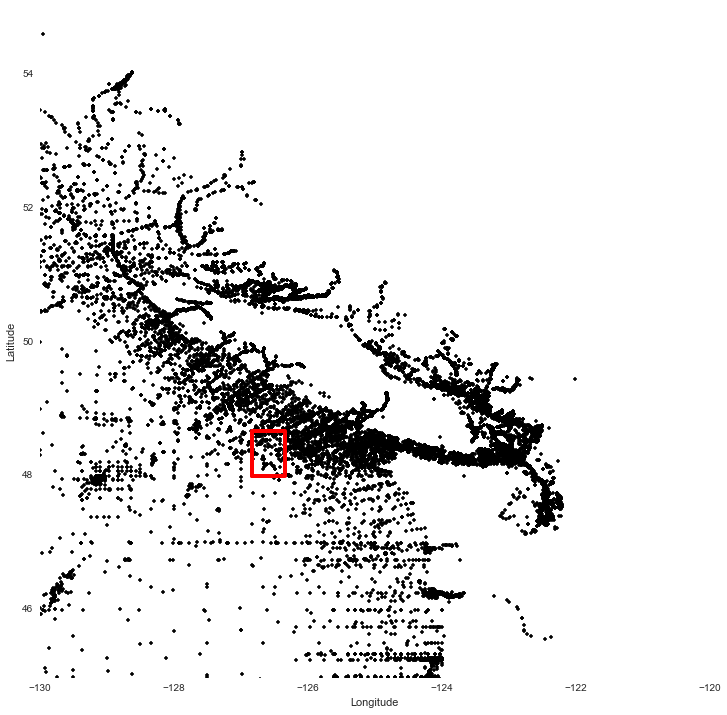

In [26]:
plt.figure(figsize=(12,12))

lats = []
lons = []
yrs = Set([])
for cast in cast_inf:
    if 'Temperatur' in cast['Variables'] and 'Salinity' in cast['Variables']:
        lats.append(cast['Latitude'])
        lons.append(cast['Longitude'])    
        yrs.add(cast['Year'])

print yrs
plt.plot(lons,lats,'.k')
x_bd_box = [FOCUS_LON_MIN,FOCUS_LON_MAX,FOCUS_LON_MAX,FOCUS_LON_MIN,FOCUS_LON_MIN]
y_bd_box = [FOCUS_LAT_MIN,FOCUS_LAT_MIN,FOCUS_LAT_MAX,FOCUS_LAT_MAX,FOCUS_LAT_MIN]
plt.plot(x_bd_box,y_bd_box,'-r',lw=4)
plt.ylim((45,55))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

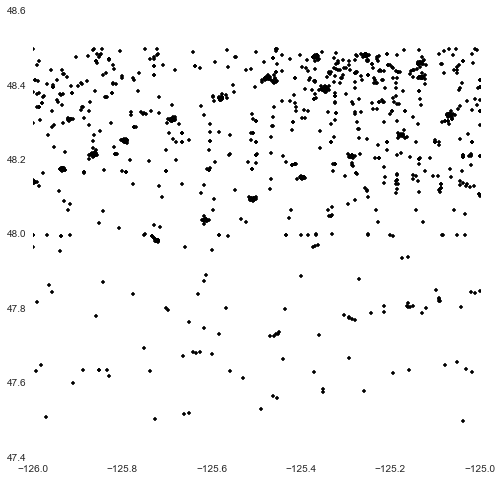

In [27]:
zm_casts = []

zm_casts = csvWOD_filter_region(cast_inf,-126,-125,47.5,48.5)

plt.figure(figsize=(8,8))

zm_lons = []
zm_lats = []

for ii in range(0,len(zm_casts)):
    zm_lons.append(zm_casts[ii]['Longitude'])
    zm_lats.append(zm_casts[ii]['Latitude'])
    
plt.plot(zm_lons,zm_lats,'.k')
plt.show()

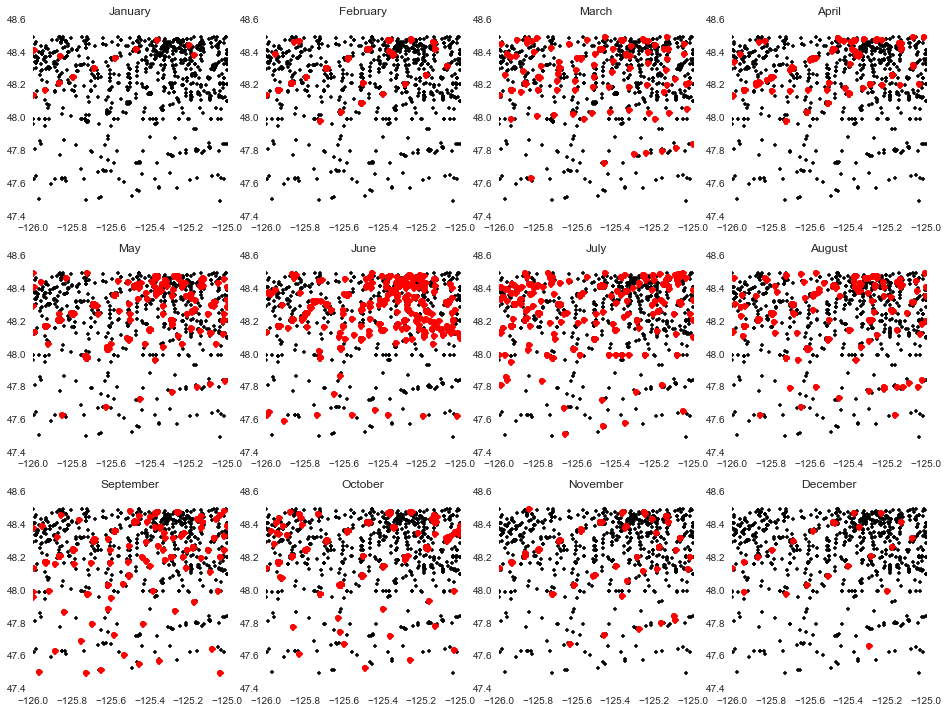

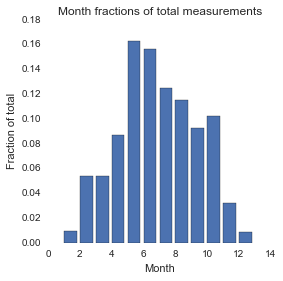

In [39]:
mnth_fracs = []

plt.figure(figsize=(16,12))
for mnth in range(1,13):
    plt.subplot(3,4,mnth)
    mnth_filt = csvWOD_filter_month(zm_casts,mnth)
    
    mnth_lons = []
    mnth_lats = []
    for ii in range(0,len(mnth_filt)):
        mnth_lons.append(mnth_filt[ii]['Longitude'])
        mnth_lats.append(mnth_filt[ii]['Latitude'])
    plt.plot(zm_lons,zm_lats,'.k')
    plt.plot(mnth_lons,mnth_lats,'or')
    plt.title(calendar.month_name[mnth])
    
    mnth_fracs.append(float(len(mnth_filt))/float(len(zm_casts)))

plt.figure(figsize=(4,4))
plt.bar(np.arange(1,13),mnth_fracs)
plt.title('Month fractions of total measurements')
plt.xlabel('Month')
plt.ylabel('Fraction of total')
plt.show()

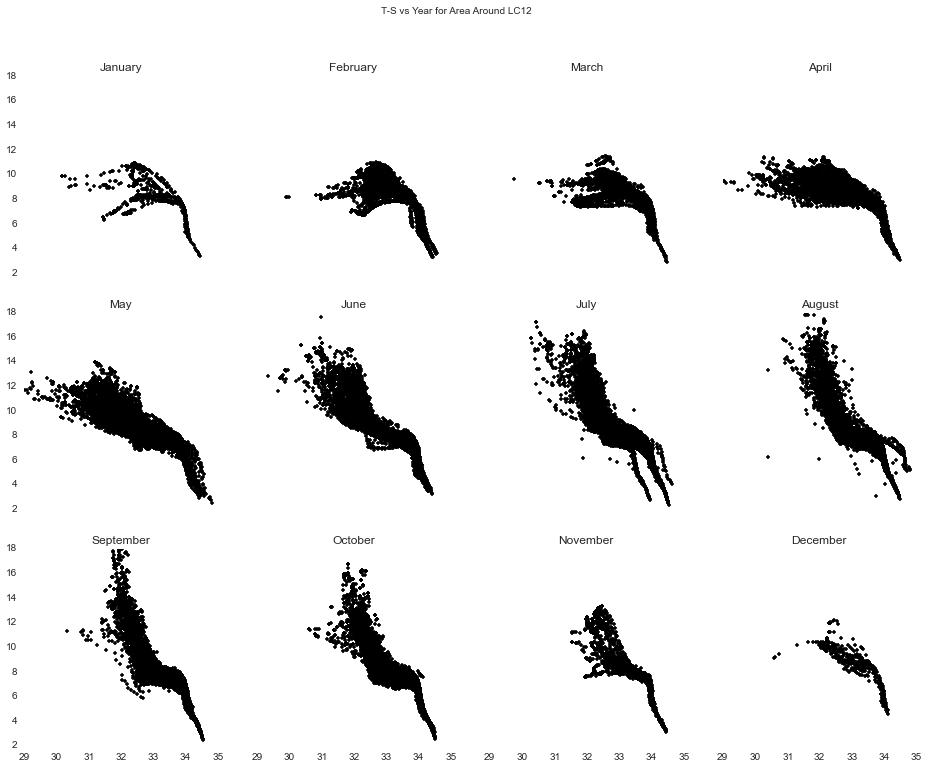

In [35]:
fig,axes=plt.subplots(3,4,figsize=(16,12),sharex=True,sharey=True)
for cnt,row in enumerate(axes):
    for cnt2,ax in enumerate(row):
        mnth = (cnt*4)+cnt2+1
        #plt.subplot(3,4,mnth)
        mnth_filt = csvWOD_filter_variables(csvWOD_filter_month(zm_casts,mnth),['Temperatur','Salinity'])
    
        #mnth_lons = []
        #mnth_lats = []
        mnth_temp = []
        mnth_saln = []
        for ii in range(0,len(mnth_filt)):
            #mnth_lons.append(mnth_filt[ii]['Longitude'])
            #mnth_lats.append(mnth_filt[ii]['Latitude'])
            mnth_temp.extend(mnth_filt[ii]['Temperatur'])
            mnth_saln.extend(mnth_filt[ii]['Salinity'])
        #plt.plot(zm_lons,zm_lats,'.k')
        ax.plot(mnth_saln,mnth_temp,'.k')
        ax.set_xlim((29,35))
        ax.set_ylim((2,18))
        ax.set_title(calendar.month_name[mnth])
        ax.grid()
        
plt.suptitle('T-S vs Year for Area Around LC12')
#plt.supxlabel('S')
#plt.supylabel('T')
plt.show()